## Imports

In [1]:
# Import some "default" libraries
# You can now use Pandas to manipulate the Dataframe conveniently

''' Data manipulation'''
import numpy as np
import pandas as pd

''' Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

# 🚀 Emlak - Gelişmiş Tahminleyici


❗️ Önceki görevde, veri setimizdeki daire sayısı ($\large n$ gözlem $\large> p$ özellik) özellik sayısından fazla olduğunda $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $ denklemini "çözemedik". $\large \boldsymbol \theta$ için deterministik bir formül olmadan, yeni dairelerin fiyatlarını tahmin edemezdik!


----


🎯 Bu alıştırmada artık 1000 daireden oluşan daha büyük bir veri setine erişimimiz var ve daha öncekiyle aynı yeni daire için tahminimizi geliştirmek istiyoruz:


- `Surface`: 3000 $ft^2$


- `Bedrooms`: 5 
- `Floors`: 1


❌ $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $ denklemini, şekli $ (1000,4)$ olan **`terslenemez`** bir matris $\large \boldsymbol X$ ile çözmek yerine...


🚀 ...$\large {\boldsymbol \theta} = \begin{bmatrix}

     \theta_0 \\

     \theta_1 \\

    \theta_2 \\

     \theta_3

\end{bmatrix}_{4 \times 1}$ vektörünü, hata $ \large \boldsymbol e = \boldsymbol X \cdot \hat{\boldsymbol \theta} - \boldsymbol y  $ en küçük olacak şekilde bulacağız.


Bu bir **`Doğrusal Regresyon Modeli`**dir. Hata $\boldsymbol e$'yi Öklidyen mesafe $\large \left\|\boldsymbol e\right\|$ ve **`Ortalama Kare Hata (MSE)`** ile ölçeceğiz.


👉 $\large \hat{\boldsymbol \theta}$ değerini hesaplayarak yeni dairenin fiyatına yaklaşık bir tahmin bulalım.

## (1) Veri Keşfi


Aşağıda `flats.csv` veri setini yüklüyoruz

In [2]:
flats = pd.read_csv('https://d32aokrjazspmn.cloudfront.net/materials/flats.csv')
flats.head(10)

,price,bedrooms,surface,floors
0,274.0,3,1830,2.0
1,500.0,4,2120,1.0
2,320.0,3,1260,1.0
3,445.5,3,1880,1.0
4,637.5,3,1680,1.0
5,460.0,2,2730,1.0
6,259.0,3,1270,1.5
7,950.0,3,2780,1.0
8,550.0,3,1930,2.0
9,265.5,3,1860,1.0


In [7]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     1000 non-null   float64
 1   bedrooms  1000 non-null   int64  
 2   surface   1000 non-null   int64  
 3   floors    1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 31.4 KB


👀 Fiyatlar hakkında en fazla bilgiyi hangi özelliğin verdiğini görsel olarak anlamak için `sns.scatterplot()` kullanın:

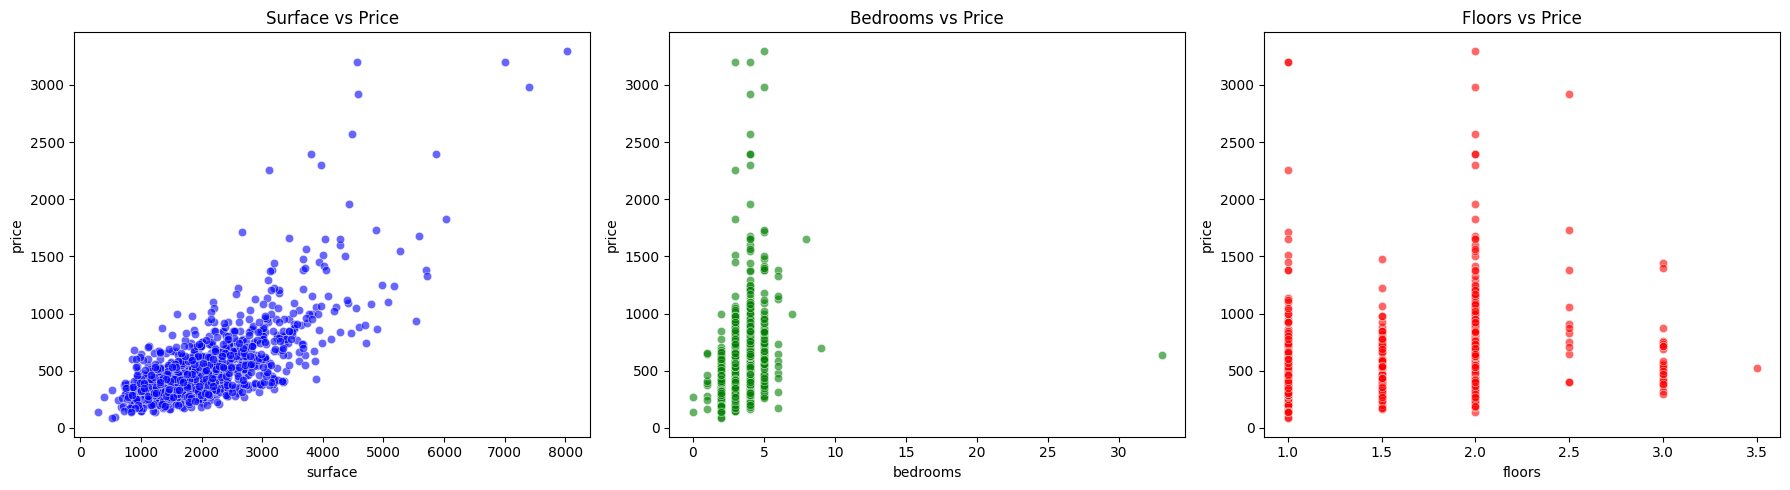

In [8]:
# Grafikleri yan yana görmek için 1 satır 3 sütunluk bir alan oluşturuyoruz
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. Surface (Yüzey) vs Price
sns.scatterplot(data=flats, x='surface', y='price', ax=ax1, color='blue', alpha=0.6)
ax1.set_title('Surface vs Price')

# 2. Bedrooms (Yatak Odası) vs Price
sns.scatterplot(data=flats, x='bedrooms', y='price', ax=ax2, color='green', alpha=0.6)
ax2.set_title('Bedrooms vs Price')

# 3. Floors (Katlar) vs Price
sns.scatterplot(data=flats, x='floors', y='price', ax=ax3, color='red', alpha=0.6)
ax3.set_title('Floors vs Price')

plt.tight_layout()
plt.show()

👉 Görünüyor ki `surface` fiyat için yatak odası veya kat sayısından daha güçlü bir gösterge. İstatistikte, `price`'ın diğer özelliklere göre `surface` ile daha **ilişkili** olduğunu söyleriz.


👉 Bunu, DataFrame'deki her sütun çifti arasındaki korelasyon katsayılarını hesaplayan [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) ile kontrol edelim.


<i> <u>Dikkat çekici değerler:</u></i>

* 1: İki sütun tamamen korelasyonlu 📈

* -1: İki sütun tamamen ters korelasyonlu 📉

* 0: İki sütun *doğrusal* olarak korelasyonlu değil 😐

    
<details>
    <summary><i>Korelasyon katsayısı neden kovaryans yerine kullanılır?</i></summary>

✅ <u>Benzerlikler</u>:

    
- 📈 Pozitif korelasyonlar ve pozitif kovaryanslar: X artarsa Y de artar, tersi de geçerli.
- 📉 Negatif korelasyonlar ve negatif kovaryanslar: X artarsa Y azalır, tersi de geçerli.
- 🤔 Sıfır korelasyon ve sıfır kovaryans: 
    - _Doğrusal olarak_ ilişkili değiller, yani $ Y = aX + b$ gibi bir ilişki yok.
    - Ancak $Y = X^{2}$ (kuadratik), $Y = e^{X}$ (üstel), $Y = ln(X)$ (logaritmik), $Y = sin(\sqrt{1+X^7})$ (çok tuhaf) gibi başka ilişkiler olabilir.

❗️<u>Ana farklar</u>:

- 😖 Kovaryans $ cov(X, Y) \in ( - \infty ; + \infty ) $ aralığında olabilir ve karşılaştırmak zordur.
    Örnek: $ cov (X, Y) = 10 $ ve $ cov (X, Z) = 30 $ ise X ve Z daha mı ilişkili? _Hayır_, çünkü birimleri farklı olabilir.

    🧑🏻‍🏫 Çözüm: Korelasyon kullanılır, genellikle $\rho$ harfiyle gösterilir.

👉 <u>Sonuç</u>:

- Korelasyon, kovaryansın standartlaştırılmış halidir: kovaryansı X ve Y'nin standart sapmasına böleriz.
$$ \large  \rho(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y} \in [0;1]$$

Örnek: $ \rho(X, Y) = 0.80 $ ve $ \rho(X, Z) = 0.15 $ ise, X ve Y daha çok ilişkilidir!
</details>

In [9]:
# Korelasyon matrisini hesaplama
correlation_matrix = flats.corr()

# Sonucu görüntüleme
print(correlation_matrix)

             price  bedrooms   surface    floors
price     1.000000  0.239623  0.732790  0.258263
bedrooms  0.239623  1.000000  0.417170  0.131993
surface   0.732790  0.417170  1.000000  0.357512
floors    0.258263  0.131993  0.357512  1.000000


🎨 Bu matrisi hızlıca görmek için [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) ile bir **ısı haritası** kullanabilirsiniz.


<details>
    <summary><i>Daha güzel bir korelasyon matrisi için ipuçları</i></summary>

- `cmap`: **Seaborn** bir görselleştirme kütüphanesi olduğu için, [`cmap`](https://matplotlib.org/stable/tutorials/colors/colormaps.html) argümanını kullanabilirsiniz.
- `annot`: Korelasyon katsayılarını doğrudan renkli harita üzerinde gösterebilirsiniz.
- `annot_kws`: Korelasyon katsayılarının görünümünü özelleştirebilirsiniz.
</details>

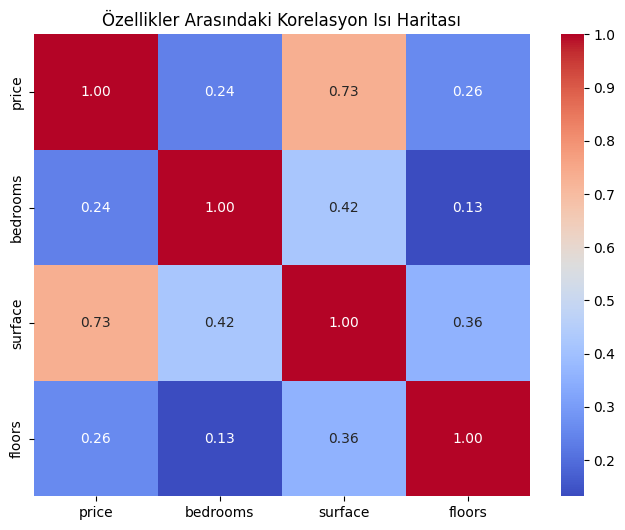

In [10]:
plt.figure(figsize=(8, 6))

# annot=True kutucukların içine sayıları yazar
# cmap='coolwarm' maviden (negatif) kırmızıya (pozitif) renk skalası verir
sns.heatmap(flats.corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Özellikler Arasındaki Korelasyon Isı Haritası")
plt.show()

**🧪 Test your code!**

In [11]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'flats',
    shape=flats.shape,
    columns=flats.columns
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/egkpnr/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /home/egkpnr/code/EGkpnr/data-real-estate-advanced-estimator/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2
collecting ... collected 2 items

test_flats.py::TestFlats::test_columns PASSED                            [ 50%]
test_flats.py::TestFlats::test_shape PASSED                              [100%]

============================== 2 passed in 0.34s ===============================


💯 You can commit your code:

git add tests/flats.pickle

git commit -m 'Completed flats step'

git push origin master



## (2) 1 Özellikli Tahminleyici


Sadece bir özellik olan **surface** ile **price** için istatistiksel bir tahminleyici oluşturalım.


🎯 İki değişken arasında **doğrusal regresyon** kuralım.


Pratikte, $\hat{\boldsymbol \theta}$ = (`eğim`, `kesişim`) parametrelerini öyle seçmek istiyoruz ki, `tahmini fiyat = eğim * surface + kesişim` ifadesi, Ortalama Kare Hata (MSE) açısından `price` değerine en yakın olsun.


📅 Önümüzdeki haftalarda farklı modelleri (Doğrusal Regresyon, KNN, Lojistik Regresyon, Sinir Ağları, vb.) keşfedeceğiz.


👉 Önemli bir işiniz doğru modeli seçmek ve parametreleri optimize ederek en iyi tahminleri yapmaktır.

### (2.1) Görsel Yaklaşım

❓`plot_line(slope, intercept)` fonksiyonunu yazın


Bu fonksiyon, `slope` ve `intercept` argümanları verildiğinde bir `predicted_price` dizisi oluşturur ve bu diziyi orijinal (dağılmış) verinin üstüne çizer.


Fonksiyonu yazdıktan sonra, farklı `(slope, intercept)` değerleriyle oynayarak veriye "iyi bir doğrusal yaklaşım" bulmaya çalışın. En iyi uyumu bulabilir misiniz?


Görsel örnek:


<img src="https://wagon-public-datasets.s3.amazonaws.com/03-Maths/01-Algebra-Calculus/line_of_best_fit.png" width=400>

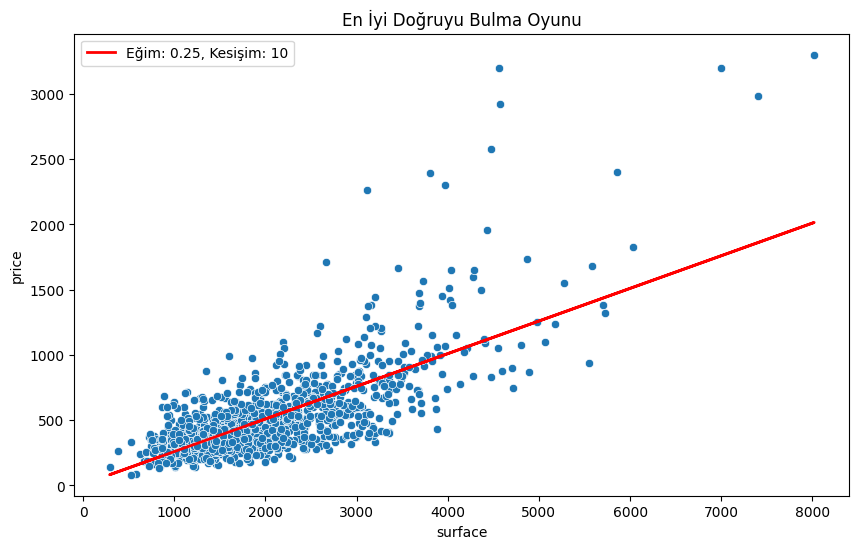

In [31]:
def plot_line(data, slope, intercept):
    # First, we'll create x - an array of our independent variable values - for you.
    x = data['surface']

    # Now create an array of predicted prices using the predicted prices formula above
    # Remember, we can do mathematical operations on an entire array at once!
    y_pred = slope * x + intercept
    

    # Finally, let's plot the line!
    plt.plot(x, y_pred, color='red', linewidth=2, label=f'Eğim: {slope}, Kesişim: {intercept}')
    plt.legend()
    
# --- Test Etme ve Oynama Alanı ---

# Önce gerçek veriyi dağılım grafiği (scatter) olarak çiz
plt.figure(figsize=(10, 6))
sns.scatterplot(x="surface", y="price", data=flats)

# Şimdi fonksiyonumuzu çağırarak çizgiyi üzerine ekle
# Buradaki değerlerle oynayarak en iyi çizgiyi bulmaya çalış!
# Örnek başlangıç değerleri: Eğim (slope)=0.2, Kesişim (intercept)=10
plot_line(flats, 0.25, 10) 

plt.title("En İyi Doğruyu Bulma Oyunu")
plt.show()

Fonksiyonunuzu aşağıdaki hücreyi çalıştırarak test edin, ardından iyi bir en küçük hata doğrusu bulmak için değerleri değiştirin!


*İpucu: Aynı hücrede `plot_line()` fonksiyonunu birden fazla kez çalıştırarak aynı dağılım grafiğinde birden fazla doğru çizebilirsiniz* 😉

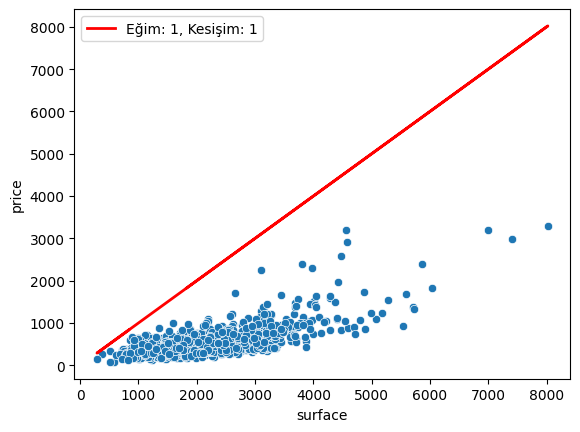

In [32]:
sns.scatterplot(x="surface", y="price", data=flats)
plot_line(flats, 1, 1)

😅 O kadar da kolay (ve çok "bilimsel" değil), değil mi?

### (2.2) Hesaplamalı Yaklaşım


🔥 Tahminleyici doğrunun en iyi olmasını sağlamak için, **gerçek fiyatlar** ile **tahmini fiyatlar** arasındaki **Ortalama Kare Hata**yı (MSE) hesaplamamız gerekir!


👉 Unutmayın:


- Her daire için `tahmini_fiyat = eğim * surface + kesişim`


- Hem **gerçek fiyat vektörü** hem de **tahmini fiyat vektörü** $ (1000, 1)$ boyutunda

#### (2.2.1) Kare Hatalar

<u><b>Adım 1</b></u>


❓Her satır (_yani daire_) için `squared_error = (price - predicted_price)**2` hesaplamalıyız❓

In [33]:
def compute_squared_errors(slope, intercept, surfaces, prices):
    """
    TODO: return an array containing the squared errors between
    all real prices from the dataset and the predicted prices
    """
# 1. Tahmin edilen fiyatları hesapla: y_pred = m*x + b
    predicted_prices = slope * surfaces + intercept
    
    # 2. Karesel Hatayı hesapla: (y_real - y_pred)^2
    squared_errors = (prices - predicted_prices) ** 2
    
    return squared_errors

💡 Veri Bilimi/Modelleme'de genel bir ilke: $ \large error = f(\boldsymbol y, \hat{\boldsymbol y})$ burada:


- $ \large \boldsymbol y $ gerçek değer


- $ \large \hat{\boldsymbol y} $ tahmini değer


- $ \large f$ genellikle **Kayıp Fonksiyonu** veya **Maliyet Fonksiyonu** olarak adlandırılır 
    - 📆 `Makine Öğrenmesi I > Model Ayarı`

#### (2.2.2) Ortalama Kare Hata (MSE)

<u><b>Adım 2</b></u>


❓ `mse` fonksiyonunu oluşturun, bu fonksiyon `squared_errors` fonksiyonundan dönen dizinin ortalamasını döndürmeli. ❓

In [34]:
def compute_mse(slope, intercept, surfaces, prices):
    '''TODO: Return the mean of the array contained in squared_errors as a float.'''
# 1. Önceki fonksiyon mantığını kullanarak hataların karelerini hesapla
    predicted_prices = slope * surfaces + intercept
    squared_errors = (prices - predicted_prices) ** 2
    
    # 2. Bu hataların ortalamasını al (Mean)
    mse = np.mean(squared_errors)
    
    # Alternatif (Numpy kullanmadan, sadece Python ile):
    # mse = sum(squared_errors) / len(squared_errors)
    
    return mse

👉 _(2.1) Görsel yaklaşım_ bölümünde, "en iyi doğruyu" yani en iyi `(slope, intercept)` çiftini görsel olarak tahmin etmeye çalıştınız.


❓Bu "en iyi çifti" kullanarak tahminleyicinizin MSE'sini hesaplayın. ❓

In [35]:
# (2.1) Bölümünde göz kararı bulduğun değerleri buraya gir:
my_slope = 0.25      # Örnek değer (Senin tahmininle değiştir)
my_intercept = 10    # Örnek değer (Senin tahmininle değiştir)

# MSE'yi hesapla
mse_score = compute_mse(my_slope, my_intercept, flats['surface'], flats['price'])

print(f"Senin tahminin için MSE Skoru: {mse_score:.2f}")

Senin tahminin için MSE Skoru: 59071.68


### (2.3) En İyi Parametreleri Bulmak


👉 Farklı `slope` ve `intercept` değerleriyle oynamaya devam edin ve en iyi uyumu elde etmeye çalışın! İki parametreyi aynı anda optimize etmenin ne kadar zor olduğunu fark edin.


👇 Aşağıdaki adımları izleyerek olası bir yaklaşım görebilirsiniz:

#### (2.3.1) En İyi Eğim Değerini Bulmak

<b><i><u> Adım 1 :</u></i></b>


`initial_intercept` için en iyi tahmininizi sabitleyerek başlayın, ardından yaklaşık olarak `mse = f(slope)` fonksiyonunu en aza indiren eğimi bulun

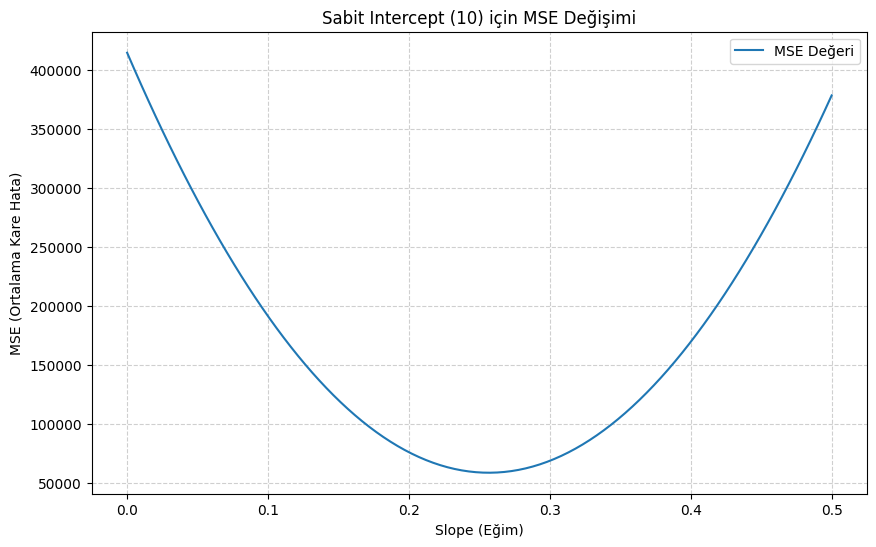

Grafiğe göre en iyi Eğim (Slope): 0.2576
Bu eğimdeki Minimum MSE: 58833.78


In [36]:
# Define an initial_intercept, for instance, we may suppose there is always a small transaction fee even for very small flats
# 1. Intercept'i (kesişim) sabitleyelim
# Örneğin, 0 metrekare bir evin bile küçük bir işlem ücreti (base price) olduğunu varsayalım.
initial_intercept = 10 

# 2. Test edilecek farklı 'slope' (eğim) değerleri oluşturalım
# 0 ile 0.5 arasında 100 farklı değer deneyeceğiz.
slopes = np.linspace(0, 0.5, 100)

# 3. Her bir eğim için MSE'yi hesaplayalım
mse_values = []
for slope in slopes:
    mse = compute_mse(slope, initial_intercept, flats['surface'], flats['price'])
    mse_values.append(mse)

# 4. MSE vs Slope Grafiğini Çizelim (Maliyet Fonksiyonu)
plt.figure(figsize=(10, 6))
plt.plot(slopes, mse_values, label='MSE Değeri')

# Görselleştirme detayları
plt.title("Sabit Intercept (10) için MSE Değişimi")
plt.xlabel("Slope (Eğim)")
plt.ylabel("MSE (Ortalama Kare Hata)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# En düşük MSE'yi veren eğimi bulalım (İsteğe bağlı ipucu)
best_slope_index = np.argmin(mse_values)
print(f"Grafiğe göre en iyi Eğim (Slope): {slopes[best_slope_index]:.4f}")
print(f"Bu eğimdeki Minimum MSE: {mse_values[best_slope_index]:.2f}")

In [37]:
# Create a range of 100 slopes that contains what you believe is the optimal slope (hint: np.linspace())
# Optimum değerimiz (0.2576) bu aralığın ortalarına düşüyor
slopes = np.linspace(0.1, 0.4, 100)

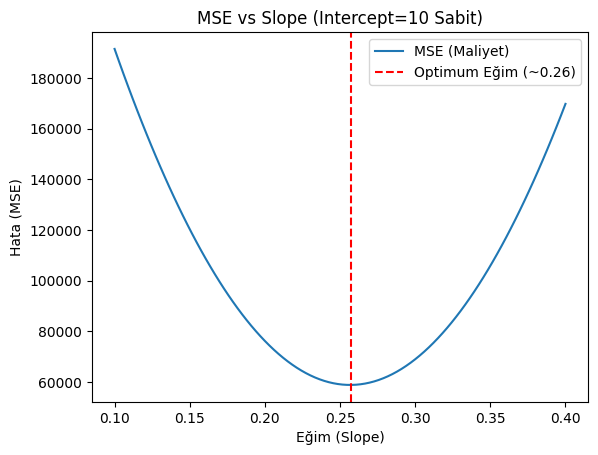

Bu aralıktaki en düşük MSE: 58833.78 (Slope: 0.2576)


In [38]:
# Create the list of MSEs for each slope value
# 1. MSE değerlerini saklayacağımız boş bir liste
mses = []

# 2. Her bir eğim (slope) için döngü
for slope in slopes:
    # intercept'i hala 10 olarak sabit tutuyoruz
    mse = compute_mse(slope, 10, flats['surface'], flats['price'])
    mses.append(mse)

# 3. Grafiği çiz
plt.plot(slopes, mses, label='MSE (Maliyet)')
plt.title("MSE vs Slope (Intercept=10 Sabit)")
plt.xlabel("Eğim (Slope)")
plt.ylabel("Hata (MSE)")
plt.axvline(0.2576, color='r', linestyle='--', label='Optimum Eğim (~0.26)') # Bulduğun noktayı işaretle
plt.legend()
plt.show()

# En düşük MSE'yi programatik olarak bulma
min_mse = min(mses)
best_slope = slopes[mses.index(min_mse)]
print(f"Bu aralıktaki en düşük MSE: {min_mse:.2f} (Slope: {best_slope:.4f})")

❓MSE'leri eğimlere karşı çizin. Bir minimum görüyor musunuz❓


🙃 Görmüyorsanız, başka bir eğim aralığı deneyin!

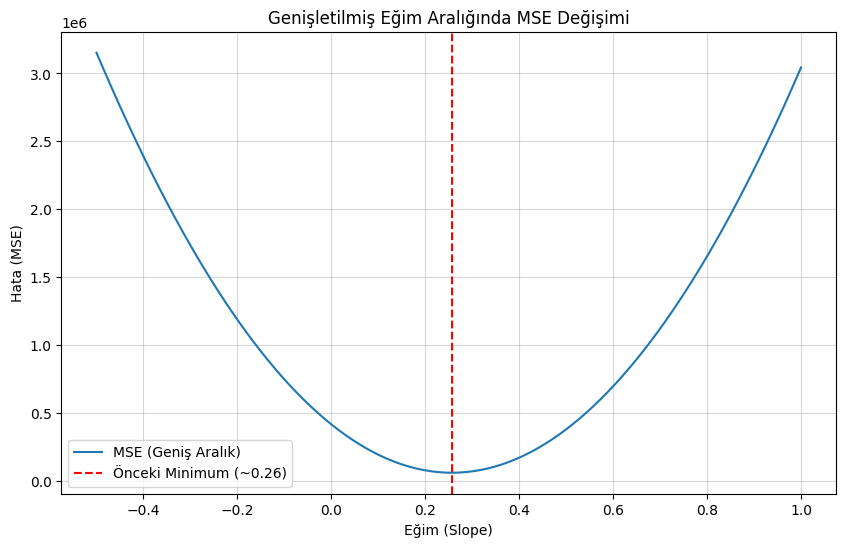

In [39]:
# 1. Aralığı çok genişletelim (Negatif eğimlerden, çok dik eğimlere)
wide_slopes = np.linspace(-0.5, 1.0, 100)
mses_wide = []

# 2. Hesaplama (Intercept hala 10 sabit)
for slope in wide_slopes:
    mse = compute_mse(slope, 10, flats['surface'], flats['price'])
    mses_wide.append(mse)

# 3. Çizim
plt.figure(figsize=(10, 6))
plt.plot(wide_slopes, mses_wide, label='MSE (Geniş Aralık)')

# Bulduğumuz eski minimum noktayı işaretleyelim
plt.axvline(0.2576, color='r', linestyle='--', label='Önceki Minimum (~0.26)')

plt.title("Genişletilmiş Eğim Aralığında MSE Değişimi")
plt.xlabel("Eğim (Slope)")
plt.ylabel("Hata (MSE)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

❓`initial_intercept` için MSE'nin minimum değerini ve karşılık gelen `slope_best` değerini hesaplayın❓


<details>
    <summary><i>İpucu</i></summary>
    
Burada Python'un yerleşik `.min()` fonksiyonunu ve `List.index()` metodunu kullanabilirsiniz
    
</details>

In [40]:
# 1. Minimum MSE değerini bul
mse_min = min(mse_values)

# 2. Bu değerin listedeki sırasını (indeksini) bul
min_index = mse_values.index(mse_min)

# 3. Aynı sıradaki eğim değerini 'slopes' listesinden al
slope_best = slopes[min_index]

print(f"Minimum MSE: {mse_min}")
print(f"En İyi Eğim (Slope Best): {slope_best}")

Minimum MSE: 58833.777149687536
En İyi Eğim (Slope Best): 0.2545454545454546


#### (2.3.2) En İyi Kesişim Değerini Bulmak

<b><i><u> Adım 2 :</u></i></b>


🔨 Şimdi, eğimi `slope_best` değerine sabitleyin ve önceki yaklaşımı tekrar kullanarak "en iyi" `intercept_best` değerini bulun.

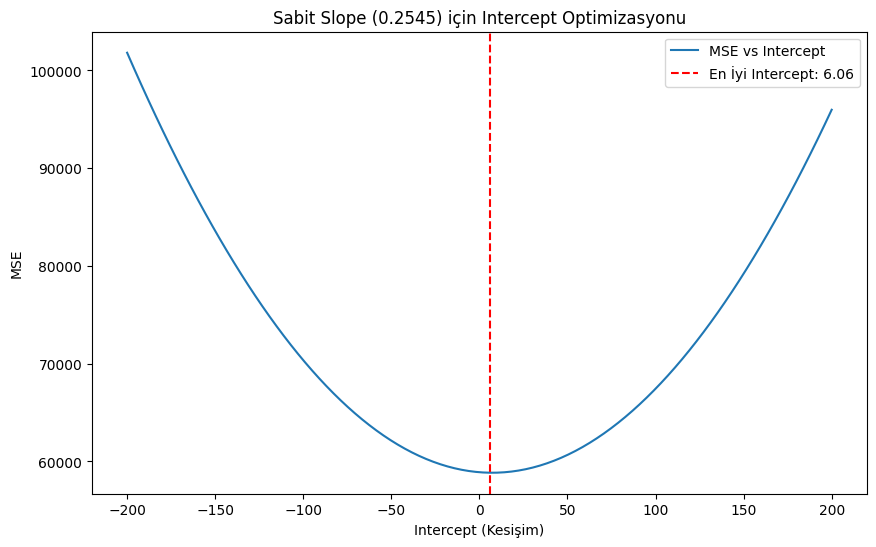

Minimum MSE: 58848.71
En İyi Intercept (intercept_best): 6.06


In [41]:
# Create a range of 100 intercepts that contains what you believe is the optimal intercept
intercepts = np.linspace(-200, 200, 100)

mses_intercepts = []

# 2. Döngü ile her intercept için MSE hesapla
# DİKKAT: slope_best'i sabit tutuyoruz!
for intercept in intercepts:
    mse = compute_mse(slope_best, intercept, flats['surface'], flats['price'])
    mses_intercepts.append(mse)

# 3. Minimum MSE ve en iyi Intercept'i bul
min_mse_int = min(mses_intercepts)
best_idx = mses_intercepts.index(min_mse_int)
intercept_best = intercepts[best_idx]

# 4. Görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(intercepts, mses_intercepts, label='MSE vs Intercept')
plt.axvline(intercept_best, color='r', linestyle='--', label=f'En İyi Intercept: {intercept_best:.2f}')
plt.title(f"Sabit Slope ({slope_best:.4f}) için Intercept Optimizasyonu")
plt.xlabel("Intercept (Kesişim)")
plt.ylabel("MSE")
plt.legend()
plt.show()

print(f"Minimum MSE: {min_mse_int:.2f}")
print(f"En İyi Intercept (intercept_best): {intercept_best:.2f}")

In [43]:
# 1. slope_best değerini önceki adımınızdan alıyoruz (yaklaşık değer)
slope_best = 0.254545  

# 2. Tahmin edilen intercept civarında bir arama aralığı oluşturuyoruz
# Bulduğun 6.06 değeri merkezde olacak şekilde geniş bir aralık seçelim (-50 ile 50 arası)
intercepts = np.linspace(-50, 50, 100)

mses = []

# 3. Her intercept için MSE hesapla (Slope SABİT)
for intercept in intercepts:
    mse = compute_mse(slope_best, intercept, flats['surface'], flats['price'])
    mses.append(mse)

# 4. En iyi değerleri bulma
min_mse = min(mses)
best_idx = mses.index(min_mse)
intercept_best_calculated = intercepts[best_idx]

print("--- SONUÇLAR ---")
print(f"Sabit Slope ({slope_best}) için;")
print(f"Minimum MSE Değeri: {min_mse:.2f}")
print(f"En İyi Intercept:   {intercept_best_calculated:.2f}")

--- SONUÇLAR ---
Sabit Slope (0.254545) için;
Minimum MSE Değeri: 58847.28
En İyi Intercept:   7.58


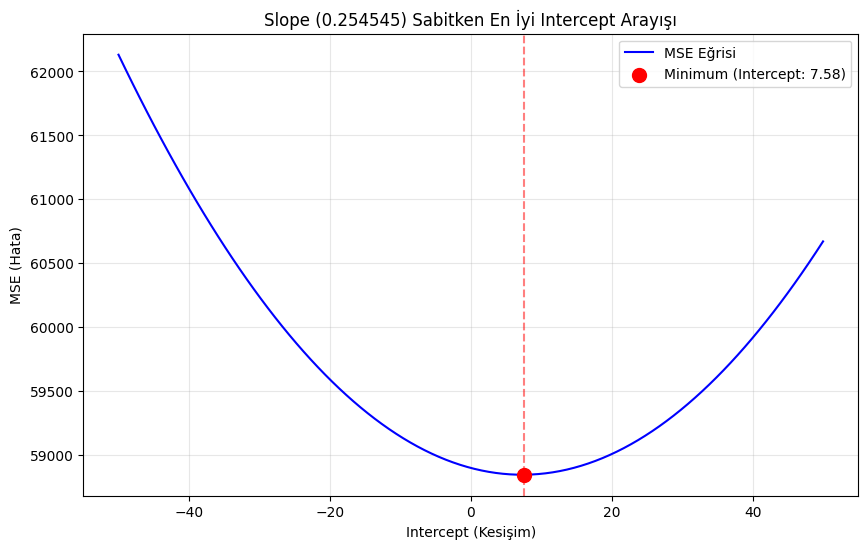

In [52]:
# Plot MSEs against intercepts. Do you see a minimum? If not, try another range of slopes!
# Grafiği oluştur
plt.figure(figsize=(10, 6))
plt.plot(intercepts, mses, label='MSE Eğrisi', color='blue')

# Bulduğun minimum noktayı işaretle
plt.scatter(intercept_best_calculated, min_mse, color='red', s=100, zorder=5, label=f'Minimum (Intercept: {intercept_best_calculated:.2f})')
plt.axvline(intercept_best_calculated, color='red', linestyle='--', alpha=0.5)

# Etiketler
plt.title(f"Slope ({slope_best}) Sabitken En İyi Intercept Arayışı")
plt.xlabel("Intercept (Kesişim)")
plt.ylabel("MSE (Hata)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

❓Eğim `slope_best` olduğunda MSE'lerin minimum değeri olan `mse_min`'i ve karşılık gelen en iyi kesişimi `intercept_best` olarak hesaplayın❓



In [53]:
# 1. Hesaplanan MSE listesindeki en küçük değeri bul
mse_min = min(mses)

# 2. Bu en küçük değerin listede kaçıncı sırada (indeks) olduğunu bul
min_index = mses.index(mse_min)

# 3. Aynı sıradaki intercept değerini al
intercept_best = intercepts[min_index]

print(f"Minimum MSE (mse_min): {mse_min}")
print(f"En İyi Intercept (intercept_best): {intercept_best}")

Minimum MSE (mse_min): 58847.280614352734
En İyi Intercept (intercept_best): 7.575757575757578


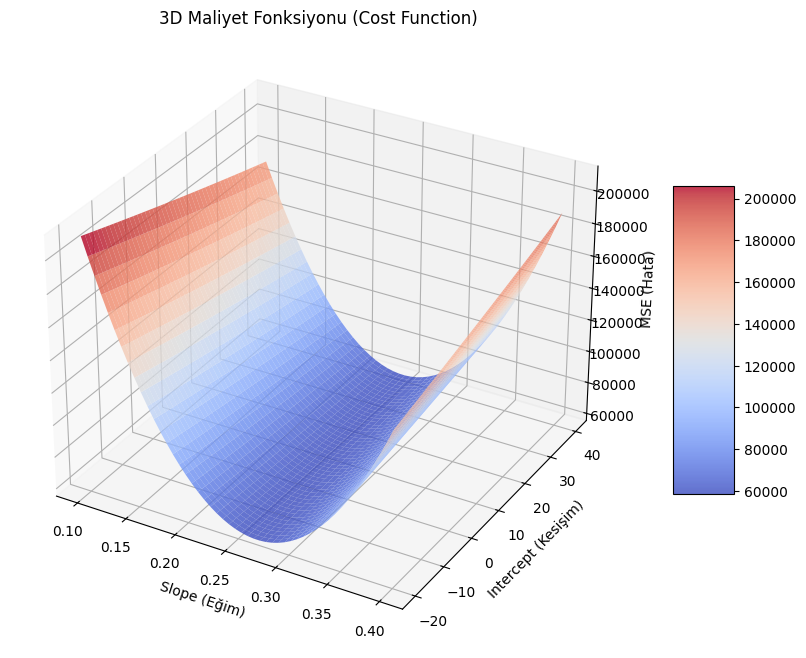

In [54]:
from matplotlib import cm
# 1. Izgara (Grid) oluştur: Hem slope hem intercept için geniş bir aralık
slopes_grid = np.linspace(0.1, 0.4, 50)
intercepts_grid = np.linspace(-20, 40, 50)

# Meshgrid ile tüm (slope, intercept) kombinasyonlarını oluşturuyoruz
S, I = np.meshgrid(slopes_grid, intercepts_grid)

# 2. Her kombinasyon için MSE hesapla (Vektörel işlem)
# Not: Burada döngü yerine daha hızlı bir numpy işlemi yapıyoruz
def vectorized_mse(s, i):
    # Bu biraz hileli ama hızlı:
    # Her (s, i) çifti için tek tek MSE hesaplamak yerine
    # broadcasting kullanarak tüm ızgarayı hesaplatıyoruz.
    # Ancak basitlik adına burada list comprehension kullanabiliriz:
    return np.array([compute_mse(s_val, i_val, flats['surface'], flats['price']) 
                     for s_val, i_val in zip(np.ravel(s), np.ravel(i))]).reshape(s.shape)

Z = vectorized_mse(S, I)

# 3. 3D Çizim
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Yüzeyi çiz
surf = ax.plot_surface(S, I, Z, cmap=cm.coolwarm, alpha=0.8, linewidth=0)

# Eksen etiketleri
ax.set_xlabel('Slope (Eğim)')
ax.set_ylabel('Intercept (Kesişim)')
ax.set_zlabel('MSE (Hata)')
ax.set_title('3D Maliyet Fonksiyonu (Cost Function)')

# Renk barı ekle
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

**🧪 Test your code!**

In [55]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'univariate',
    mse_min=mse_min,
    slope_best=slope_best,
    intercept_best=intercept_best
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/egkpnr/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /home/egkpnr/code/EGkpnr/data-real-estate-advanced-estimator/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2
collecting ... collected 3 items

test_univariate.py::TestUnivariate::test_best_intercept PASSED           [ 33%]
test_univariate.py::TestUnivariate::test_best_slope PASSED               [ 66%]
test_univariate.py::TestUnivariate::test_mse PASSED                      [100%]

============================== 3 passed in 0.08s ===============================


💯 You can commit your code:

git add tests/univariate.pickle

git commit -m 'Completed univariate step'

git push origin master



🎉 **Harika iş**! Sıfır olmayan bir kesişim parametresi ekleyerek MSE'yi daha da azalttık (yaklaşık uyumu görsel olarak doğrulamak için regresyon doğrusunu dağılım grafiğinizde çizebilirsiniz).


❓Peki, bu (`intercept_best`, `slope_best`) parametrelerinin gerçekten en iyi değerler olduğuna ne garanti verir? 

<details>
    <summary>👀 Açıklamalar (<strong>bunu dikkatlice okuyun!</strong>)</summary>


Belki de adım ①'i tekrar ederek, bu sefer kesişimi `intercept_best`'e sabitleyip, ardından adım ②'yi yeni eğimle tekrar ederek daha iyi bir eğim değeri bulabiliriz.


İki parametreli bir fonksiyonun `rmse = f(slope, intercept)` global minimumunu bulmak için, adım ① ve ②'yi sonsuza kadar tekrarlamamız gerekebilir - başarı garantisi olmadan.


<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/decision-science/real-estate-minimizer.png'>


💪 Makine Öğrenmesinin en temel yönlerinden birini keşfettiniz: **minima bulma sürecinin tekrarlılığı**.


👉 Tahmin edebileceğiniz gibi, Veri Bilimi dünyasında bu tür süreçleri otomatikleştiren ve optimize eden algoritmalar geliştirilmiştir. Sonraki ünitelerde, bu tekrarlama işlemini sizin için yapan **Gradient Descent** gibi algoritmaların gücünü keşfedeceksiniz.
</details>

👉 Merak ediyorsanız ve bu veri seti için gerçek en iyi eğim ve kesişimi bulmak istiyorsanız aşağıdaki hücreleri çalıştırın.

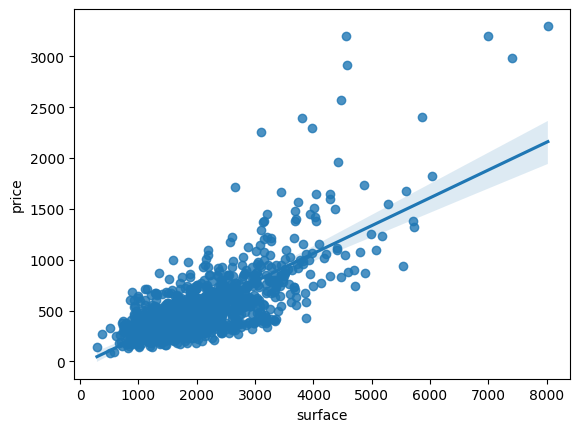

In [58]:
# Try this out (Seaborn visual solution)
sns.regplot(data=flats, x='surface', y='price');

In [59]:
# Try this out (statsmodels, exact solution)!
import statsmodels.formula.api as smf

regression = smf.ols(formula= 'price ~ surface', data=flats).fit()

print("intercept_best", regression.params['Intercept'])
print("slope_best", regression.params['surface'])
print('mse_best: ', np.mean(regression.resid**2))

intercept_best -33.30833598535581
slope_best 0.27369043218689093
mse_best:  58515.12390949639


❓Başlangıç sorumuza geri dönelim: Aşağıdaki 5. daire için yeni tahmininiz nedir? Sadece 4 daireye dayalı ilk tahmininizle nasıl karşılaştırılır?


- `surface`: 3000 $ft^2$


- `bedrooms`: 5 
- `floors`: 1

In [60]:
# compute predicted price (Remember that the real price is 750,000$)
# 1. Statsmodels tarafından bulunan optimal değerler
intercept_best = -33.308336
slope_best = 0.273690

# 2. Yeni dairenin yüzey alanı
surface_flat5 = 3000

# 3. Tahmin Hesaplama: y = mx + c
predicted_price = slope_best * surface_flat5 + intercept_best

print(f"Yeni Model Tahmini: {predicted_price:.2f} bin $")

Yeni Model Tahmini: 787.76 bin $


☝️ Sadece 4 daireye dayalı ilk deterministik tahminleyicimizden daha iyi, ancak bu tahminde yatak odası ve kat sayısının sağladığı bilgiyi kaçırıyoruz!

## (3) _Tüm_ Özelliklerle Tahminleyici (`surface`, `bedrooms`, `floors`)?

💡 Üç özellikli bir doğrusal regresyon (**Çok Değişkenli Doğrusal Regresyon**) tek özellikliyle aynı şekilde çalışır, ancak RMSE'yi en aza indirmek için sadece 2 parametre değil, 4 parametre bulmamız gerekir: $\hat{\boldsymbol \theta}$ = (`intercept`, `slope_surface`, `slope_bedrooms`, `slope_floors`).


🗓 Bu **Çok Değişkenli Doğrusal Regresyon**u **Karar Bilimi** modülünde daha ayrıntılı inceleyeceğiz.


🗓 Kapalı analitik çözümle (bir sonraki bölümde göreceksiniz) Ordinary Least Squares regresyonu hesaplanabilir, ancak hesaplama açısından çok karmaşık olabilir.


🗓 Bu yüzden genellikle yukarıda bahsedilen **Gradient Descent** gibi yinelemeli yöntemler kullanılır. Makine Öğrenmesinde çok güçlü ve önemli bir yöntemdir ve bootcamp'te kendiniz kodlayacaksınız.


👉 Bu arada, aşağıdaki hücreyi çalıştırarak bu çok değişkenli regresyonun nihai sonucunu görebilirsiniz:

In [61]:
# Find the four regression coefficients by running this cell
regression = smf.ols(formula= 'price ~ surface + bedrooms + floors', data=flats).fit()
regression.params

Intercept    18.154854
surface       0.286953
bedrooms    -21.623564
floors       -3.811868
dtype: float64

🎉 Artık en iyi parametreleri bulduğumuza göre:

$$
\boldsymbol{\hat{\theta}} = 
\begin{bmatrix}
    \theta_0 \\
    \theta_1 \\
    \theta_2 \\
    \theta_3
\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}
    \theta_{intercept} \\
    \theta_{surface} \\
    \theta_{bedrooms} \\
    \theta_{floors}
\end{bmatrix} = 
\begin{bmatrix}
    18.154854 \\
    0.286953 \\
    -21.623564 \\
    -3.811868
\end{bmatrix}
$$

Yeni dairenin fiyatını şu özelliklerle tahmin edebiliriz:
* $3000 \text{ ft}^2$
* $5$ yatak odası
* $1.$ kat

$$\hat{y}_5 = \theta_0 + \theta_1 \cdot 3000 + \theta_2 \cdot 5 + \theta_3 \cdot 1$$

In [62]:
# Compute the newly predicted price for the 5th flat? Is this prediction better?
# 1. Model Katsayıları (Theta Değerleri)
theta_intercept = 18.154854
theta_surface = 0.286953
theta_bedrooms = -21.623564
theta_floors = -3.811868

# 2. 5. Dairenin Özellikleri
flat5_surface = 3000
flat5_bedrooms = 5
flat5_floors = 1

# 3. Tahmin Hesaplaması (Dot Product)
# y_pred = theta_0 + (theta_1 * x_1) + (theta_2 * x_2) + (theta_3 * x_3)
predicted_price = theta_intercept + \
                  (theta_surface * flat5_surface) + \
                  (theta_bedrooms * flat5_bedrooms) + \
                  (theta_floors * flat5_floors)

print(f"5. Daire için Yeni Tahmin: {predicted_price:.2f} bin $")

5. Daire için Yeni Tahmin: 767.08 bin $


## (4) Concluding Remarks on Linear Algebra 🧠

Bu **optimizasyon problemi** şöyle özetlenebilir:

* $\hat{\boldsymbol{\theta}} = \begin{bmatrix} \theta_{intercept} \\ \theta_{surface} \\ \theta_{bedrooms} \\ \theta_{floors} \end{bmatrix}_{4 \times 1}$ vektörünü bulmamız gerekir.

* $e = \left\|\boldsymbol{X} \cdot \hat{\boldsymbol{\theta}} - \boldsymbol{y} \right\|^2$ hatasını en küçük yapan değeri arıyoruz.

* **Özellikler matrisi** $\boldsymbol{X}$ (sabit, surface, bedrooms, floors):
    $$
    \boldsymbol{X} = 
    \begin{bmatrix}
    1 & 620 & 1 & 1 \\
    1 & 3280 & 4 & 2 \\
    \vdots & \vdots & \vdots & \vdots \\
    1 & 1900 & 2 & 2 \\
    1 & 1320 & 3 & 3
    \end{bmatrix}_{n \times 4}
    $$

* ve **gözlem vektörü** (fiyatlar):
    $$
    \boldsymbol{y} = 
    \begin{bmatrix}
    y_{1} \\
    y_{2} \\
    \vdots \\
    y_{1000}
    \end{bmatrix}_{n \times 1}
    $$

Böyle bir $\hat{\boldsymbol{\theta}}$, şu türev sıfıra eşitlendiğinde elde edilir (👉 ispatı Karar Bilimi modülündeki Doğrusal Regresyon dersinde bulabilirsiniz):

$$2 \boldsymbol{X}^T \cdot (\boldsymbol{X} \cdot \hat{\boldsymbol{\theta}} - \boldsymbol{y}) = 0$$

Başka bir deyişle, şu doğrusal sistemi çözmemiz gerekir:

$$(\boldsymbol{X}^T \cdot \boldsymbol{X}) \cdot \hat{\boldsymbol{\theta}} = \boldsymbol{X}^T \cdot \boldsymbol{y}$$

Bu doğrusal sistemin **tek bir çözümü** vardır, eğer $\boldsymbol{X}$'in hiçbir sütunu diğerlerinin doğrusal birleşimiyle ifade edilemiyorsa. Bu durumda $(\boldsymbol{X}^T \cdot \boldsymbol{X})$ terslenebilirdir ve minimum şu formül ile bulunur (**Normal Denklem**):

$$\large \hat{\boldsymbol{\theta}} = (\boldsymbol{X}^T \cdot \boldsymbol{X})^{-1} \cdot \boldsymbol{X}^T \cdot \boldsymbol{y}$$

> *Dikkat edin, $\boldsymbol{X}$ artık ilk görevdeki gibi kare matris olmak zorunda değildir 💪.*

---

💥 **Önemli Not:** Matrisleri tersini almak (inverse) hesaplama açısından **çok maliyetlidir**. 
Bu yüzden büyük veri setlerinde minimumu bulmak için **Gradient Descent (Bayır İnişi)** gibi yinelemeli yöntemler geliştirilmiştir.

📚 Daha fazla bilgi için [Stats.StackExchange](https://stats.stackexchange.com/a/278779) adresini inceleyin!

🏁 Tebrikler! 


💾 Not defterinizi `git add/commit/push` ile kaydetmeyi unutmayın!